## Import Functions

In [15]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import multi_gpu_model
import numpy as np
import pandas as pd
import math
import random
import sys
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from mpl_finance import candlestick2_ohlc
import datetime
from collections import deque

## Defining The Agent

In [2]:
class Agent:
    def __init__(self, state_size, is_eval=False, model_name=""):
        self.state_size = state_size # normalized previous days
        self.action_size = 3 # sit, buy, sell
        self.memory = deque(maxlen=1000)
        self.inventory = []
        self.model_name = model_name
        self.is_eval = is_eval
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = self._model()
        #self.model = load_model("/Users/maharshichattopadhyay/Documents/Study/Major_Project/Model/" + model_name) if is_eval else self._model()
    def _model(self):
        model = Sequential()
        model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(units=8, activation="relu"))
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(lr=0.001))
        return model
    def act(self, state):
        if not self.is_eval and random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        options = self.model.predict(state)
        return np.argmax(options[0])
    def expReplay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])
        for state, action, reward, next_state, done in mini_batch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
    #def load_checkpoint(self, path):
        #self.model.load_weights(path)

## Plot Function

In [11]:
def plot(csv,sell_time):
    df=pd.read_csv(csv)
    date=df['Date']
    open=df['Open']
    high=df['High']
    low=df['Low']
    close=df['Close']
    fig=plt.figure(figsize=(7,5))
    graph=fig.add_subplot(1,1,1)
    graph.plot(date,close,color='red')
    candlestick2_ohlc(graph,open,high,low,close,colorup="blue",colordown="red",width=2,alpha=0.5)

## Math-Functions
#### Intuition: This Function Defines How The Input Will Be Processed and The Output Will Be Shown

In [3]:
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))
def getStockDataVec(CSV):
    vec = []
    lines = open(CSV, "r").read().splitlines()
    for line in lines[1:]:
        vec.append(float(line.split(",")[8]))# Selecting The Close Price And Multiplying it By 1000
    return vec
def sigmoid(x):
    return 1 / (1 + math.exp(-x))
def getState(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))
    return np.array([res])

## Importing From GPU To CPU

In [4]:
def make_parallel(model, gpu_count):
    def get_slice(data, idx, parts):
        shape = tf.shape(data)
        size = tf.concat([ shape[:1] // parts, shape[1:] ],axis=0)
        stride = tf.concat([ shape[:1] // parts, shape[1:]*0 ],axis=0)
        start = stride * idx
        return tf.slice(data, start, size)
    outputs_all = []
    for i in range(len(model.outputs)):
        outputs_all.append([])

    #Place a copy of the model on each GPU, each getting a slice of the batch
    for i in range(gpu_count):
        with tf.device('/gpu:%d' % i):
            with tf.name_scope('tower_%d' % i) as scope:

                inputs = []
                #Slice each input into a piece for processing on this GPU
                for x in model.inputs:
                    input_shape = tuple(x.get_shape().as_list())[1:]
                    slice_n = Lambda(get_slice, output_shape=input_shape, arguments={'idx':i,'parts':gpu_count})(x)
                    inputs.append(slice_n)                

                outputs = model(inputs)

                if not isinstance(outputs, list):
                    outputs = [outputs]

                #Save all the outputs for merging back together later
                for l in range(len(outputs)):
                    outputs_all[l].append(outputs[l])
     # merge outputs on CPU
    with tf.device('/cpu:0'):
        merged = []
        for outputs in outputs_all:
            merged.append(merge(outputs, mode='concat', concat_axis=0))

        return Model(input=model.inputs, output=merged)

## Training The Model

In [5]:
stock_name="/Users/maharshichattopadhyay/Documents/Study/Major_Project/DataSet/Final_Dataset/Final_Data_MCB_Train.csv"
window_size=10
episode_count = 2
agent = Agent(window_size)
data = getStockDataVec(stock_name)
l = len(data) - 1
batch_size = 32
#path = '/Users/maharshichattopadhyay/Desktop/Model/No_Of_Episodes_380.h5'
#agent.load_checkpoint(path)
for e in range(episode_count + 1):
    print("Episode " + str(e) + "/" + str(episode_count))
    state = getState(data, 0, window_size + 1)
    total_profit = 0
    agent.inventory = []
    for t in range(l):
        action = agent.act(state)
        # sit
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0
        if action == 1: # buy
            agent.inventory.append(data[t])
            print("Buy: " + formatPrice(data[t]))
        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = agent.inventory.pop(0)
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))
        done = True if t == l - 1 else False
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state
        if done:
            print("--------------------------------")
            print("Total Profit: " + formatPrice(total_profit))
            print("--------------------------------")
        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)
        if e % 10 == 0:
            filepath="/Users/maharshichattopadhyay/Documents/Study/Major_Project/Model/No_Of_Episodes_" + str(e)+".hdf5"
            agent.model.save(filepath)

Instructions for updating:
Colocations handled automatically by placer.
Episode 0/2
Buy: $223.61
Buy: $229.00
Sell: $238.50 | Profit: $14.89
Buy: $242.10
Buy: $239.55
Sell: $238.05 | Profit: $9.05
Sell: $229.10 | Profit: -$13.00
Sell: $228.25 | Profit: -$11.30
Buy: $229.76
Sell: $232.50 | Profit: $2.74
Buy: $231.40
Buy: $225.00
Sell: $222.00 | Profit: -$9.40
Sell: $227.80 | Profit: $2.80
Buy: $228.00
Buy: $222.04
Buy: $213.50
Buy: $206.50
Sell: $210.10 | Profit: -$17.90
Buy: $213.55
Instructions for updating:
Use tf.cast instead.
Sell: $213.25 | Profit: -$8.79
Sell: $206.00 | Profit: -$7.50
Sell: $205.55 | Profit: -$0.95
Buy: $205.03
Buy: $203.50
Buy: $210.60
Sell: $216.50 | Profit: $2.95
Buy: $224.00
Buy: $226.10
Sell: $223.61 | Profit: $18.58
Buy: $225.17
Sell: $213.62 | Profit: $10.12
Sell: $214.01 | Profit: $3.41
Sell: $192.20 | Profit: -$31.80
Sell: $193.20 | Profit: -$32.90
Buy: $194.60
Sell: $195.00 | Profit: -$30.17
Sell: $202.00 | Profit: $7.40
Buy: $206.55
Sell: $207.11 | Pro

Sell: $213.80 | Profit: -$0.48
Buy: $191.99
Buy: $188.25
Buy: $182.20
Buy: $184.00
Buy: $187.01
Buy: $187.00
Buy: $188.50
Sell: $190.90 | Profit: -$19.35
Buy: $189.99
Buy: $190.00
Buy: $190.90
Buy: $188.25
Buy: $189.00
Buy: $188.86
Sell: $189.55 | Profit: -$2.44
Sell: $190.00 | Profit: $1.75
Sell: $193.85 | Profit: $11.65
Sell: $194.80 | Profit: $10.80
Sell: $196.00 | Profit: $8.99
Sell: $197.20 | Profit: $10.20
Sell: $198.20 | Profit: $9.70
Sell: $197.01 | Profit: $7.02
Sell: $198.76 | Profit: $8.76
Sell: $199.51 | Profit: $8.61
Sell: $198.06 | Profit: $9.81
Sell: $201.00 | Profit: $12.00
Sell: $203.50 | Profit: $14.64
Buy: $273.00
Buy: $274.51
Buy: $274.61
Sell: $275.50 | Profit: $2.50
Buy: $269.00
Buy: $265.00
Buy: $255.50
Buy: $256.00
Buy: $265.10
Buy: $260.10
Buy: $261.50
Buy: $265.00
Buy: $268.90
Buy: $277.01
Buy: $288.00
Buy: $306.01
Sell: $309.50 | Profit: $34.99
Buy: $311.50
Sell: $310.15 | Profit: $35.54
Sell: $312.25 | Profit: $43.25
Sell: $307.21 | Profit: $42.21
Sell: $302

Sell: $309.50 | Profit: $13.05
Sell: $311.00 | Profit: $10.00
Sell: $315.00 | Profit: $16.01
Sell: $317.05 | Profit: $26.05
Sell: $319.00 | Profit: $20.98
Sell: $324.60 | Profit: $20.50
Sell: $328.13 | Profit: $29.13
Sell: $333.00 | Profit: $34.50
Sell: $331.60 | Profit: $33.10
Sell: $328.30 | Profit: $31.80
Sell: $330.00 | Profit: $34.00
Sell: $330.10 | Profit: $49.10
Sell: $329.06 | Profit: $46.81
Sell: $332.01 | Profit: $49.46
Sell: $332.00 | Profit: $55.24
Sell: $327.80 | Profit: $49.47
Sell: $319.80 | Profit: $41.20
Sell: $312.90 | Profit: $32.79
Sell: $313.60 | Profit: $30.10
Sell: $313.00 | Profit: $27.80
Sell: $303.20 | Profit: $18.60
Buy: $237.00
Buy: $236.00
Buy: $226.77
Buy: $235.00
Buy: $243.00
Buy: $256.00
Buy: $254.75
Buy: $259.40
Buy: $257.50
Buy: $250.00
Buy: $245.00
Buy: $254.00
Buy: $257.65
Sell: $257.00 | Profit: $20.00
Sell: $258.73 | Profit: $22.73
Sell: $258.65 | Profit: $31.88
Sell: $260.12 | Profit: $25.12
Sell: $272.50 | Profit: $29.50
Sell: $283.00 | Profit: $

Buy: $202.15
Buy: $204.06
Sell: $205.25 | Profit: $3.10
Sell: $206.55 | Profit: $2.49
Buy: $260.10
Sell: $261.50 | Profit: $1.40
Buy: $311.50
Sell: $310.15 | Profit: -$1.35
Buy: $243.27
Sell: $244.00 | Profit: $0.73
Buy: $267.02
Buy: $267.50
Buy: $270.09
Buy: $276.00
Buy: $277.00
Buy: $278.15
Buy: $281.40
Buy: $282.30
Buy: $281.02
Buy: $279.00
Buy: $252.71
Buy: $257.00
Sell: $253.50 | Profit: -$13.52
Sell: $251.30 | Profit: -$16.20
Sell: $242.12 | Profit: -$27.97
Sell: $234.51 | Profit: -$41.49
Sell: $236.10 | Profit: -$40.90
Sell: $235.90 | Profit: -$42.25
Sell: $238.93 | Profit: -$42.47
Sell: $247.15 | Profit: -$35.15
Sell: $249.50 | Profit: -$31.52
Sell: $251.00 | Profit: -$28.00
Sell: $259.42 | Profit: $6.71
Sell: $262.05 | Profit: $5.05
Buy: $285.30
Buy: $283.15
Buy: $283.11
Buy: $281.00
Sell: $280.80 | Profit: -$4.50
Sell: $280.35 | Profit: -$2.80
Sell: $278.50 | Profit: -$4.61
Sell: $279.21 | Profit: -$1.79
Buy: $289.00
Buy: $282.00
Buy: $279.15
Buy: $278.50
Sell: $280.10 | Prof

Buy: $287.00
Buy: $286.52
Buy: $286.00
Buy: $285.50
Buy: $285.50
Buy: $289.35
Buy: $288.00
Buy: $289.00
Buy: $297.05
Buy: $297.00
Buy: $291.54
Buy: $293.00
Buy: $296.50
Buy: $297.00
Buy: $293.00
Sell: $293.80 | Profit: $34.38
Buy: $294.11
Buy: $296.45
Buy: $301.00
Buy: $298.99
Buy: $295.00
Sell: $291.00 | Profit: $28.95
Sell: $291.00 | Profit: $27.80
Sell: $292.00 | Profit: $22.75
Sell: $298.02 | Profit: $26.21
Buy: $304.10
Sell: $299.00 | Profit: $27.00
Sell: $299.65 | Profit: $25.38
Sell: $298.05 | Profit: $22.05
Sell: $297.16 | Profit: $27.16
Sell: $298.50 | Profit: $31.50
Sell: $298.50 | Profit: $27.10
Sell: $296.50 | Profit: $22.50
Sell: $296.00 | Profit: $20.00
Sell: $296.50 | Profit: $22.00
Sell: $295.00 | Profit: $20.00
Sell: $293.00 | Profit: $16.50
Sell: $293.13 | Profit: $13.63
Sell: $297.99 | Profit: $16.09
Sell: $298.00 | Profit: $18.25
Sell: $303.00 | Profit: $23.00
Sell: $302.30 | Profit: $20.60
Sell: $298.50 | Profit: $18.95
Sell: $300.06 | Profit: $20.46
Sell: $300.61 

Sell: $223.61 | Profit: -$35.55
Sell: $220.84 | Profit: -$35.76
Sell: $221.75 | Profit: -$24.76
Sell: $221.01 | Profit: -$20.29
Sell: $220.80 | Profit: -$12.25
Sell: $215.50 | Profit: -$21.30
Buy: $223.98
Buy: $222.90
Buy: $222.50
Buy: $221.15
Buy: $215.00
Buy: $212.00
Buy: $212.00
Buy: $211.70
Buy: $212.99
Buy: $213.12
Buy: $212.91
Buy: $206.00
Sell: $206.10 | Profit: -$32.00
Sell: $205.76 | Profit: -$30.23
Sell: $207.00 | Profit: -$25.00
Sell: $209.00 | Profit: -$23.50
Sell: $212.95 | Profit: -$22.15
Sell: $213.10 | Profit: -$22.50
Sell: $213.10 | Profit: -$24.90
Sell: $212.70 | Profit: -$32.30
Sell: $211.00 | Profit: -$38.70
Sell: $208.50 | Profit: -$53.50
Sell: $208.80 | Profit: -$56.20
Sell: $208.60 | Profit: -$55.40
Sell: $209.75 | Profit: -$55.25
Sell: $208.10 | Profit: -$55.40
Sell: $213.75 | Profit: -$47.30
Sell: $214.00 | Profit: -$48.14
Buy: $206.01
Buy: $207.01
Buy: $206.06
Buy: $211.00
Buy: $211.00
Buy: $214.00
Buy: $211.50
Buy: $217.86
Buy: $219.00
Buy: $224.10
Buy: $227.

## Testing The Model

In [9]:
stock_name="/Users/maharshichattopadhyay/Documents/Study/Major_Project/DataSet/Final_Dataset/Final_Data_MCB_Test.csv"
model_name = "/Users/maharshichattopadhyay/Documents/Study/Major_Project/Model/No_Of_Episodes_100.hdf5"
model = agent.model.load_weights(model_name)
#model = agent.model.load_weights(model_name)[-4]
window_size = agent.model.layers[0].input.shape.as_list()[1]
agent = Agent(window_size, True, model_name)
data = getStockDataVec(stock_name)
l = len(data) - 1
batch_size = 32
state = getState(data, 0, window_size + 1)
total_profit = 0
sell_time=[]
agent.inventory = []
for t in range(l):
    action = agent.act(state)
    # sit
    next_state = getState(data, t + 1, window_size + 1)
    reward = 0
    if action == 1: # buy
        agent.inventory.append(data[t])
        print("Buy: " + formatPrice(data[t]))
    elif action == 2 and len(agent.inventory) > 0: # sell
        bought_price = agent.inventory.pop(0)
        reward = max(data[t] - bought_price, 0)
        total_profit += data[t] - bought_price
        print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))
        sell_time=formatPrice(data[t])
    done = True if t == l - 1 else False
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state
    if done:
        print("--------------------------------")
        print(stock_name + " Total Profit: " + formatPrice(total_profit))
        print("--------------------------------")

Buy: $233.90
Sell: $233.00 | Profit: -$0.90
Buy: $232.51
Sell: $234.50 | Profit: $1.99
Buy: $236.80
Buy: $232.62
Buy: $232.35
Sell: $232.00 | Profit: -$4.80
Buy: $234.00
Buy: $235.51
Buy: $235.00
Buy: $237.90
Buy: $240.00
Buy: $239.80
Buy: $237.00
Buy: $236.60
Sell: $238.10 | Profit: $5.48
Buy: $238.70
Buy: $244.00
Buy: $254.00
Buy: $249.50
Buy: $244.51
Sell: $239.00 | Profit: $6.65
Sell: $242.00 | Profit: $8.00
Sell: $242.10 | Profit: $6.59
Buy: $242.48
Buy: $242.70
Buy: $242.00
Sell: $248.90 | Profit: $13.90
Sell: $241.00 | Profit: $3.10
Buy: $241.00
Sell: $240.00 | Profit: $0.00
Buy: $238.50
Sell: $237.00 | Profit: -$2.80
Buy: $236.21
Sell: $237.00 | Profit: $0.00
Buy: $229.75
Buy: $226.60
Buy: $225.10
Sell: $225.50 | Profit: -$11.10
Buy: $224.00
Buy: $221.00
Buy: $225.00
Buy: $226.00
Buy: $226.70
Buy: $228.00
Buy: $228.00
Buy: $229.50
Sell: $228.00 | Profit: -$10.70
Buy: $226.00
Sell: $226.52 | Profit: -$17.48
Sell: $229.00 | Profit: -$25.00
Buy: $232.16
Buy: $233.00
Buy: $236.00
B

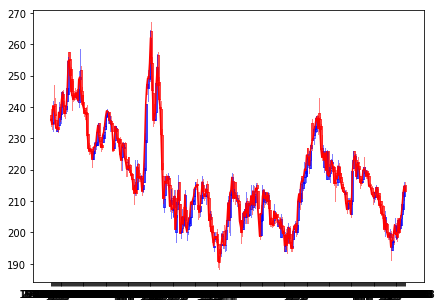

In [16]:
plot(stock_name,sell_time)